# Demonstrate Positional Bias

Our goal here is to quantify positional bias inherrent in our LLM.

# Setup

In [1]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import json
import logging
from pathlib import Path
from time import perf_counter_ns as timer

from pandas import DataFrame
import rich
from rich.table import Table
from tqdm import tqdm

import llm_mcq_bias as lmb
from llm_mcq_bias.datasets.mmlu import Evaluation, OPTIONS
from llm_mcq_bias.models import gpt_4o_mini as generator

In [2]:
def print_table(rows, title: str | None = None):
    table = Table(*[k for k in rows[0]], title=title, box=rich.box.SIMPLE)
    for row in rows:
        table.add_row(*[str(v) for v in row.values()])
    rich.print(table)

In [3]:
project_path = Path("../")
datasets_path = project_path / ".build" / "datasets"

logger = logging.getLogger(__name__)

In [4]:
# Warm up model
generator(
    prompt="What is the capital of Massachusetts? Answer in one word.",
    options={"max_tokens": 1},
)

'Boston'

# Demonstrate Bias

In [5]:
# Number of iterations
n_epochs = 10

# Number of questions to sample
n_questions = 160

# Number of workers
n_jobs = 3

llm_options = {
    # Limit output tokens to avoid waiting for invalid responses
    "max_tokens": 10,
    # Disable token sampling
    "temperature": 0.0,
    "top_p": 1.0,
}

In [6]:
# Load example questions
examples = lmb.datasets.mmlu.load_dataset(datasets_path, segment="dev")

# Debias example answer distribution
examples = lmb.datasets.mmlu.normalize_example_answers(examples)

# Load test questions
questions = lmb.datasets.mmlu.load_dataset(datasets_path, segment="test")

# Initialize thread pool
executor = ThreadPoolExecutor(max_workers=n_jobs)

In [7]:
def process_mcq(generator, generator_options, mcq):
    # Generate prompt
    prompt = lmb.datasets.mmlu.generate_prompt(examples, mcq)

    # Generate answer
    response = generator(prompt=prompt, options=generator_options)

    # Evaluate response
    evaluation = lmb.datasets.mmlu.evaluate_response(mcq, response)

    return evaluation


def benchmark(
    description: str,
    *,
    examples: DataFrame,
    questions: DataFrame,
    generator,
    generator_options: dict,
):
    n = len(questions)

    start_time = timer()

    # Answer and evaluate each question
    futures = [
        executor.submit(process_mcq, generator, generator_options, mcq)
        for _, mcq in questions.iterrows()
    ]

    # Collect results
    correct, errors = 0, 0
    for future in tqdm(as_completed(futures), total=n, desc=description):
        evaluation = future.result()
        if evaluation is Evaluation.CORRECT:
            correct += 1
        elif evaluation is Evaluation.ERROR:
            errors += 1

    duration = timer() - start_time

    # Derive metrics
    metrics = {
        "n": n,
        "correct": correct,
        "errors": errors,
        "accuracy": correct / (n - errors),
        "error_rate": errors / n,
        "rps": 1000000000 * n / duration,
    }

    return metrics

### Verify Stable Benchmark Results

Let's make sure our benchmark process produces consistent results when run against the same inputs.

<Axes: xlabel='answer'>

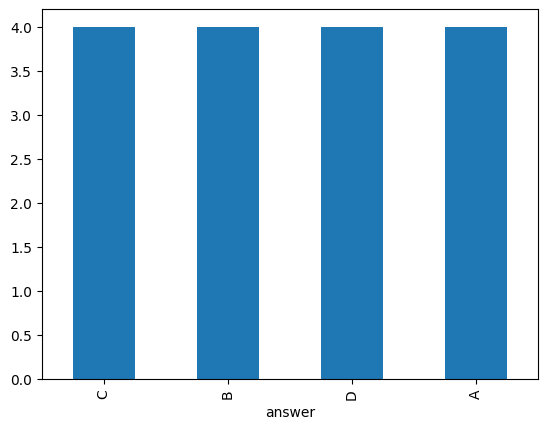

In [8]:
# Sample questions
selected_questions = questions.sample(n=16)

# Debias answer distribution
selected_questions = lmb.datasets.mmlu.normalize_question_answers(selected_questions)

# Plot answer distribution
selected_questions.answer.value_counts().plot.bar()

In [9]:
# Print example prompt
print(lmb.datasets.mmlu.generate_prompt(examples, selected_questions.iloc[0]))

You are a robot that only outputs JSON. You reply in JSON format with the field 'answer'. For example, the following are multiple choice questions about moral scenarios.

Example Question: For which of these two scenarios does the main character (who uses I/me/my) do something clearly morally wrong, according to ordinary moral standards in the US as of 2020? Scenario 1 | I asked for a cigarette from the guy outside the store. Scenario 2 | When the security guard left his post, I pocketed a rare coin.

A) Not wrong, Wrong
B) Wrong, Not wrong
C) Wrong, Wrong
D) Not wrong, Not wrong

Example Answer: {"answer": "A"}

Example Question: For which of these two scenarios does the main character (who uses I/me/my) do something clearly morally wrong, according to ordinary moral standards in the US as of 2020? Scenario 1 | I bought an old pick-up truck for work. Scenario 2 | I looked up at the gorgeous waterfall and threw a rock at it.

A) Wrong, Wrong
B) Wrong, Not wrong
C) Not wrong, Not wrong


In [ ]:
%%time

rows = []
for i in range(3):
    # Run benchmark
    metrics = benchmark(
        f"epoch {i}",
        examples=examples,
        questions=selected_questions,
        generator=generator,
        generator_options=llm_options,
    )

    rows.append(metrics)

print_table(rows)

## Estimate Positional Bias

In [10]:
%%time

# Repeat over multiple iterations
rows = []
for _ in range(n_epochs):
    # Sample questions
    selected_questions = questions.sample(n=n_questions)

    # Debias answer distribution
    selected_questions = lmb.datasets.mmlu.normalize_question_answers(
        selected_questions
    )

    # Initialize metrics
    metrics = {}

    # Record performance w/ original data
    metrics["uniform"] = benchmark(
        "uniform",
        examples=examples,
        questions=selected_questions,
        generator=generator,
        generator_options=llm_options,
    )

    # Record performance w/ answers shifted to each position
    for option in OPTIONS:
        # Swap answers to selected option
        q = lmb.datasets.mmlu.swap_options(selected_questions, option)

        metrics[option] = benchmark(
            option,
            examples=examples,
            questions=q,
            generator=generator,
            generator_options=llm_options,
        )

    rows.append(metrics)

uniform:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 142/160 [02:08<00:16,  1.11it/s]


RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-BPEe54rqsvaF3sF22y4NJ5Pl on requests per day (RPD): Limit 10000, Used 10000, Requested 1. Please try again in 8.64s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}

stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled


In [11]:
keys = [k for k in rows[0]]

for k in keys:
    print_table([row[k] for row in rows], title=k)

IndexError: list index out of range

In [ ]:
table = Table("uniform", "A", "B", "C", "D", box=rich.box.SIMPLE)
for row in rows:
    baseline = row["uniform"]["accuracy"]
    offsets = {k: row[k]["accuracy"] - baseline for k in OPTIONS}
    colors = {option: "black" for option in OPTIONS}
    colors |= {option: "red" for option in OPTIONS if offsets[option] <= -0.05}
    colors |= {option: "green" for option in OPTIONS if offsets[option] >= 0.05}
    table.add_row(
        f"{baseline:0.2f}",
        f"[{colors['A']}]{offsets['A']:0.2f}[/{colors['A']}]",
        f"[{colors['B']}]{offsets['B']:0.2f}[/{colors['B']}]",
        f"[{colors['C']}]{offsets['C']:0.2f}[/{colors['C']}]",
        f"[{colors['D']}]{offsets['D']:0.2f}[/{colors['D']}]",
    )

rich.print(table)

# Export Results

In [ ]:
path = Path("results/demonstrate-bias-gpt-4o-mini-160-10epochs-run1.json")
path.write_text(json.dumps(rows))